
Here we start working with distributions. We will also start to pay closer attention to how fast (or slow) we are making our 
functions and methods.

**Resource:**

* Shonkwiler, Ronald W., and Franklin Mendivil. 2009. Explorations in Monte Carlo Methods. New York: Springer-Verlag. https://www.springer.com/us/book/9780387878362 (October 19, 2020).




In [682]:
import numpy as np
import random as random
import matplotlib.pyplot as plt


# Discrete Distributions and Inverse CDF
We can get a samples from a discrete distribution using the inverse of the CDF. Randomly get a number between U(0,1), then compare that probability to the break point of the cdf. Essentially it is just a comparison of the probabilities with each discrete having some range between 0,1 according to the probability it will be chosen. 

*Terms:* 
**Bernoulli trial**: Distribution of two states or values (True/False, 0/1, ON/OFF, etc...) 

In [91]:
# Set up CDF
outcome = [2,3,4,5] # Discrete outcomes, for example how  many eggs a bird may lay
probabilities = [.15, .2, .6, .05] # Probabilities for the outcomes above

# Create a breakpoint array by summing the probabilites of all elements before it\
break_points = [x+np.sum(probabilities[0:idx]) for idx, x in enumerate(probabilities)]
break_points

[0.15, 0.35, 0.95, 1.0]

In [6]:
def inverse_cdf(bp, oc):
    """
    :param bp: break_point array
    :param oc: outcome array
    :return selected, u: returns the selected index and the number used to determine the selected index. 
    """
    u = random.random()
    selected = 0 
    while  u >= bp[selected]:
        selected+=1
    return selected, u
selected, u = inverse_cdf(break_points, outcome)
print(f"Outcome of {outcome[selected]} eggs is selected at probability {u:.3f}")

Outcome of 4 eggs is selected at probability 0.950


### Decreasing run time by sorting

We can speed this up by sorting probabilites by decreasing probability. The largest probability situation will come first, so less steps in the loop are needed to reach the most probable outcome. 

In [158]:
# Set up CDF, but reverse sort the break_points  
def get_sorted_breakpoints(probabilities, outcome):
    #Stick the probabilites and outcome in a matrix (matrices are easier for my brain to keep track of lol)
    mat = np.transpose(np.asarray([probabilities, outcome]))

    # Get the indices after sorting on the first column, reverse it, and sort the rows of the matrix
    mat = mat[mat[:,0].argsort()[::-1]]

    # get the break point and outcome sorted lists 
    break_points_sorted = [x+np.sum(mat[0:idx, 0]) for idx, x in enumerate(mat[:,0])]
    outcome_sorted = list(mat[:,1]) # Keep the types the same for our comparison
    return break_points_sorted, outcome_sorted

break_points_sorted, outcome_sorted = get_sorted_breakpoints(probabilities, outcome)

In [58]:
# Compare the performance of the sorted arrays with inverse cdf
print("Unsorted array: ")
%timeit -n 100000 -r 7 inverse_cdf(break_points, outcome)
# Get average time for original array
print("Sorted array:")
%timeit -n 100000 -r 7 inverse_cdf(break_points_sorted, outcome_sorted)

Unsorted array: 
592 ns ± 154 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Sorted array:
414 ns ± 34.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Decreasing run time by indexing arrays

Alternatively, we can round all probabilites to the hundreds place and use the random number as an index 


In [50]:
# for the respective outcome

breakpoint_outcome_array=[0]*101
old_p = 0
for p,k in zip(break_points,outcome):
    rounded_int_p = int(p*100)
    breakpoint_outcome_array[old_p:rounded_int_p]=[k for _ in range(old_p,rounded_int_p)]
    old_p = rounded_int_p
    
def inverse_cdf_array(bp_array):
    """
    :param bp: break_point array
    :param oc: outcome array
    :return selected, u: returns the selected index and the number used to determine the selected index. 
    """
    u = int(random.random()*100) # this is faster than randint
    return bp_array[u]


In [57]:
# Compare the break point array against all the methods so far
print("Unsorted array: ")
%timeit -n 1000000 -r 7 inverse_cdf(break_points, outcome)
# Get average time for original array
print("Sorted array:")
%timeit -n 1000000 -r 7 inverse_cdf(break_points_sorted, outcome_sorted)
print("Break point array: ")
%timeit -n 1000000 -r 7 inverse_cdf_array(breakpoint_outcome_array)

Unsorted array: 
515 ns ± 30.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
Sorted array:
381 ns ± 8.26 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
Break point array: 
315 ns ± 17.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


### Taking advantage of vectorization

We can use numpy arrays and vectorization to generate a large number of samples at once fairly quickly. 

In [83]:
#Now generate a large number of samples using vector
def inverse_cdf_vector(bp,oc, samples=1000):
    u = np.random.rand(samples)
    selection = np.empty(samples)
    old_p = 0
    for p,k in zip(bp,oc):
        mask = np.equal(old_p < u, u < p)
        selection[mask] = k
        old_p = p
    return selection

In [89]:
# Is it faster to random.random in a list comprehension or numpy's random?
%timeit [random.random() for _ in range(10000)]
%timeit np.random.rand(10000)

933 µs ± 37.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
59.7 µs ± 746 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [90]:
# How fast is it to get 10000 samples with the vector method?
%timeit -n 100 -r 7 inverse_cdf_vector(break_points, outcome, samples=10000)
# Compare this to the array method for 10000 samples
%timeit -n 100 -r 7 [inverse_cdf_array(breakpoint_outcome_array) for i in range(10000)]

264 µs ± 5.22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.37 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Walker's Alias Method

Unlike the inverse cdf, the alias method is away to get samples without using a search loop. The idea is as follows:

1) let $U = U(0,1)$ and put $Y = int[U M]$ and $Z = frac(U M)$, where $frac(x) = x - int[x]$

2) if $Q(Y) < Z$ return $ X = Y $, else return $ X = A(Y)$

**I'm pretty sure the book messed up equation #2, they had Q(Y)/M, but that doesnt give the right distribution**

Z is distributyed as U(0,1)

where M is the total number of possible outcomes. And the product of U and M will give the sample Y. At equal probability for each condition nothing would need to be done. However, we can use a second array $Q$ to adjust the down $Y$ if the actual probabilies are lower. Meanwhile, excess probability can be sent to some index $A(Y)$ whose selection exceeds the equal probability. 


In [159]:
# probabiilty of the sex of the offspring from a femail rufous vanga bird being female given a clutch size of 8. 
outcome = [0,1,2,3,4,5,6,7,8]
probs = [0.02, 0.04, 0.08, 0.15, 0.2, 0.21, 0.16, 0.09, 0.05]


Calculating Q is a little confusing at first. 

Start finding the Q(0) for the smallest probabilities first: 


$\frac{Q(0)}{M} = 0.02$ solving for $Q(0)$ gives 0.18.


Now index 0 occurs at the correct frequency. We need to give the remaining/excess probability to a value with a probability above 1/M. The amount of excess is calculated as: 

$\frac{1-Q(0)}{M}=0.091$


We will assign this to the outcome with greatest probability, in this case that is outcome 5 with a probability of 0.21

$P(5) = P(5)-0.091 = 0.21 - 0.091 = 0.209$

Continue to do this for each element


In [687]:
def set_up_alias(prob):
    probs = prob[::]
    M = len(probs)
    A = [np.nan]*M
    Q = [0]*M
    for x in np.argsort(probs):
        q_x = probs[x] * M
        Q[x]=q_x
        if probs[x]<1/M:
            q_excess = (1-q_x)/M
            A[x] = np.argmax(probs)
            if q_excess >0:
                probs[np.argmax(probs)]-=q_excess
    
    return np.asarray(Q), np.asarray(A)


In [688]:
Q,A = set_up_alias(probs)

In [679]:
def walker_alias(outcomes, Q,A, M):
    u = random.random()
    um = u*M
    Y = int(um)
    Z = um%1
    if Q[Y] > Z:
        return outcomes[Y]
    else:
        return outcomes[int(A[Y])]

In [680]:
walker_alias(outcome, Q, A.astype(np.int), len(outcome))

7

In [689]:
%timeit walker_alias(outcome, Q, A, len(outcome))

bp, oc = get_sorted_breakpoints(probs, outcome)
%timeit inverse_cdf(bp,oc)

963 ns ± 53 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
638 ns ± 49.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Soooooo, this alias method as written is fairly slower than the inverse cdf functions. But maybeeee it performs better where there is a larger number of options to have to search through. Or when we are looking thousands of samples at once. 

In [670]:
def walker_alias_vector(outcomes:np.array, Q:np.array, A:np.array, samples=10000):
    """
    maybe we can vectorize
    """
    M = len(outcomes)
    u = np.random.rand(samples)
    Y = np.multiply(u,M).astype(np.int)
    Z = np.mod(u*M,1)
    
    #
    selected = np.empty(samples)
    selected[:]=Y
    mask = np.less(Q[Y], Z) & ~np.isnan(A[Y])
    selected[mask]=A[Y[mask]]
    return selected
    

In [676]:
%timeit -n 1000 walker_alias_vector(np.asarray(outcome), np.asarray(Q), np.asarray(A), samples=10000)
%timeit -n 1000 inverse_cdf_vector(bp,oc,samples=10000)

346 µs ± 4.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
447 µs ± 43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


It appears it slightly outperforms the inverse cdf when dealing with arrays. 

In [674]:
# Lets use the Q and A from the book
#Q = [0.18, 0.36, 0.72, 1.0, 0.97, 0.43, 0.68, 0.81, 0.45]
#A = [5,5,4,3,3,6,3,6,4]
alias= walker_alias_vector(np.asarray(outcome), np.asarray(Q), np.asarray(A), samples=10000)
inv = inverse_cdf_vector(bp,oc,samples=10000)

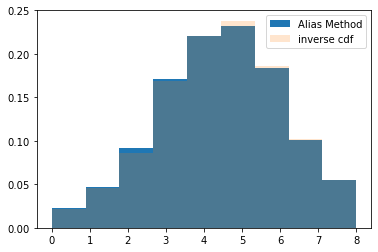

In [684]:
#Plot the two distributions, they should be close to equal
plt.figure()
plt.hist(alias,bins=M, density=True, label='Alias Method')
plt.hist(inv, alpha=0.2, bins=M, density=True, label='inverse cdf')
plt.legend()